<a href="https://colab.research.google.com/github/neelsathwara1/Diwali-Sales-Analysis/blob/Study/HACNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

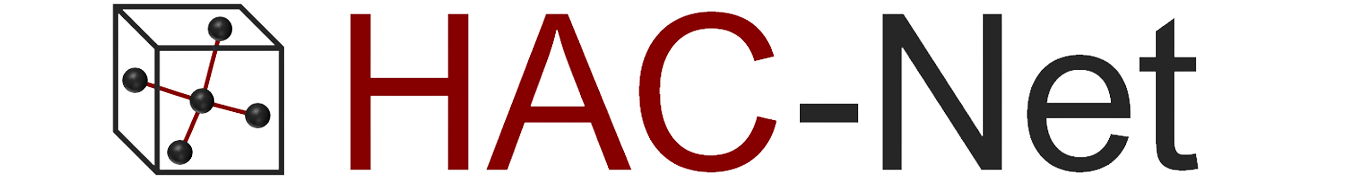

**This Colab notebook allows you to easily and quickly predict the binding affinity between a protein and ligand using [HACNet v1.4.2](https://github.com/gregory-kyro/HAC-Net). For more details, check out the associated [journal article](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00251) or [open-access article](https://arxiv.org/abs/2212.12440). Additionally, the software is available as open-source on [GitHub](https://github.com/gregory-kyro/HAC-Net).**

**For a complete tutorial on how to use this notebook to predict $pK_{D}$, please navigate to this [demo video](https://www.linkedin.com/feed/update/urn:li:activity:7059553793595555840/).**

**It is important to note that since HAC-Net was trained on docked complexes with nontrivial binding affinities, it should only be used to score protein-ligand pairs that bind.**

**For details regarding the implementation in this notebook, please see [this document](https://github.com/gregory-kyro/HAC-Net/blob/main/HACNet/predict_pkd_info.txt).**

**Feel free to reach out via email with any questions or concerns:**

**gregory.kyro@yale.edu** &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **rafi.brent@yale.edu**

**In order to properly run this notebook:**

**Step 1 - run the first cell to begin setting up the environment of the notebook (this will crash the runtime)**

**Step 2 - after the notebook has crashed, run the first cell again to finish setting up the notebook environment**

**Step 3 - upload protein (pdb) and ligand (mol2) files to the notebook, as shown in the demo video**

**Step 4 - type the names of the uploaded files into the second cell, select the type of output you would like to receive, and run the second cell**

In [2]:
#@title Set Up Environment { display-mode: "form" }

#@markdown **Please execute this cell by pressing the *Play* button on the left
#@markdown to set up the environment of the notebook to run HACNet. This will
#@markdown initially crash the notebook to reconfigure the environment --
#@markdown please then press *Play* again.**

# hide outputs
%%capture

# install condacolab
!pip install -q condacolab

# import condacolab
import condacolab

# install condacolab environment
condacolab.install()

# import condacolab
import condacolab

# check that the environment has been initialized properly
condacolab.check()

# install openbabel
!conda install -c conda-forge openbabel

# install pymol
!mamba install pymol-open-source --yes

# install biopandas
!pip install biopandas

# import torch
import torch

# install necessary torch packages
!pip install torch-geometric torch-scatter torch-sparse \
 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

# install HACNet
!pip install HACNet

 # import predict_pkd function from HACNet package
from HACNet.functions import predict_pkd

# clone GitHub repository containing parameter files for HAC-Net
!git clone https://github.com/gregory-kyro/HAC-Net.git

# define xml file containing atomic features
elements_xml = '/content/HAC-Net/HACNet/element_features.xml'

# define 3D-CNN parameter file
cnn_params = '/content/HAC-Net/HACNet/parameter_files/CNN_parameters.pt'

# define GCN parameter file
gcn0_params = '/content/HAC-Net/HACNet/parameter_files/GCN0_parameters.pt'

# define other GCN parameter file
gcn1_params = '/content/HAC-Net/HACNet/parameter_files/GCN1_parameters.pt'

# define MLP parameter file
mlp_params = '/content/HAC-Net/HACNet/parameter_files/MLP_parameters.pt'

In [3]:
#@title Inference Function

from biopandas.pdb import PandasPdb
from biopandas.mol2 import PandasMol2
import numpy as np
from pymol import cmd
import requests
import xml.etree.ElementTree as ET
import openbabel.pybel
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
from torch_geometric.nn.conv import MessagePassing, GatedGraphConv
from torch_geometric.nn import global_add_pool
from torch_geometric.utils import add_self_loops, dense_to_sparse
from torch_geometric.nn.aggr import AttentionalAggregation
from torch._C import NoneType
from torch.optim import Adam
from torch_geometric.data import Data, DataListLoader
from torch_geometric.nn import DataParallel as GeometricDataParallel
from torch.utils.data import Dataset
import numpy as np
import h5py
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, pairwise_distances
import os
import random
from scipy import stats
import matplotlib.pyplot as plt

from IPython.display import Image, display

os.chdir('/content/HAC-Net/HACNet')

from CNN import *
from GCN import *

""" define a function to predict pkd for a single protein-ligand complex """
def predict_pkd(protein_pdb, ligand_mol2, elements_xml, cnn_params, gcn0_params, gcn1_params, mlp_params, verbose=True):

  """
  Inputs:
  1) protein_pdb: path to protein pdb file
  2) ligand_mol2: path to ligand mol2 file
  3) verbose: if True, will return pkd and image of protein-ligand complex.
      If False, will return float corresponding to predicted pkd. Default is True

  Output:
  1) Prediction of pkd
  2) visual of protein-ligand complex (if verbose == True)
  """

  """ define function to extract pocket from protein pdb """
  def extract_pocket(protein_pdb, ligand_mol2):

    # read in protein pdb file
    protein =  PandasPdb().read_pdb(protein_pdb)

    # define protein atoms dataframe
    protein_atom = protein.df['ATOM'].reset_index(drop=True)

    # create protein atom dictionary
    protein_atom_dict = protein_atom.to_dict('index')

    # define protein heteroatoms dataframe
    protein_hetatm =  protein.df['HETATM'].reset_index(drop=True)

    # create protein heteroatom dictionary
    protein_hetatm_dict = protein_hetatm.to_dict('index')

    # read in ligand mol2 file
    ligand = PandasMol2().read_mol2(ligand_mol2).df

    # define ligand non-H atoms dataframe
    ligand_nonh = ligand[ligand['atom_type'] != 'H'].reset_index(drop=True)

    # create ligand non-H atom dictionary
    ligand_nonh_dict = ligand_nonh.to_dict('index')

    # initialize lists to save IDs for residues and heteroatoms to keep in pocket file
    pocket_residues = []
    pocket_heteroatoms = []

    # for each protein atom:
    for j in range(len(protein_atom_dict)):

      # if residue number is not already saved in list
      if protein_atom_dict[j]['residue_number'] not in pocket_residues:

        # for each ligand non-H atom:
        for i in range(len(ligand_nonh_dict)):

          # if Euclidean distance is within 8 Angstroms:
          if np.sqrt((ligand_nonh_dict[i]['x'] - protein_atom_dict[j]['x_coord'])**2 + (ligand_nonh_dict[i]['y'] - protein_atom_dict[j]['y_coord'])**2 + (ligand_nonh_dict[i]['z'] - protein_atom_dict[j]['z_coord'])**2) <= 8:

            # save chain ID, residue number and insertion to list
            pocket_residues.append(str(protein_atom_dict[j]['chain_id'])+'_'+str(protein_atom_dict[j]['residue_number'])+'_'+str(protein_atom_dict[j]['insertion']))

            break

    # for each protein heteroatom:
    for k in range(len(protein_hetatm_dict)):

      # if residue number is not already saved in list
      if protein_hetatm_dict[k]['residue_number'] not in pocket_heteroatoms:

        # for each ligand non-H atom:
        for i in range(len(ligand_nonh_dict)):

          # if Euclidean distance is within 8 Angstroms:
          if np.sqrt((ligand_nonh_dict[i]['x'] - protein_hetatm_dict[k]['x_coord'])**2 + (ligand_nonh_dict[i]['y'] - protein_hetatm_dict[k]['y_coord'])**2 + (ligand_nonh_dict[i]['z'] - protein_hetatm_dict[k]['z_coord'])**2) <= 8:

            # save heteroatom ID to list
            pocket_heteroatoms.append(protein_hetatm_dict[k]['residue_number'])

            break

    # initialize list to store atoms that are included in saved residues
    atoms_to_keep = []

    # loop through atom dictionary
    for k,v in protein_atom_dict.items():

      # if atom is in saved list
      if str(v['chain_id'])+'_'+str(v['residue_number'])+'_'+str(v['insertion']) in pocket_residues:

        # append the atom number to new list
        atoms_to_keep.append(v['atom_number'])

    # define the atoms to include in pocket
    residues = protein_atom[(protein_atom['atom_number'].isin(atoms_to_keep))]

    # reset atom number ordering
    residues = residues.reset_index(drop=1)

    # initialize list to store heteroatoms that are included in saved heteroatom IDs
    hetatms_to_keep = []

    # loop through heteroatom dictionary
    for k,v in protein_hetatm_dict.items():

      # if heteroatom is in saved list
      if v['residue_number'] in pocket_heteroatoms and v['residue_name']=='HOH':

        # append the heteroatom number to new list
        hetatms_to_keep.append(v['atom_number'])

    # define the heteroatoms to include in pocket file
    heteroatoms = protein_hetatm[(protein_hetatm['atom_number'].isin(hetatms_to_keep))]

    # reset heteroatom number ordering
    heteroatoms = heteroatoms.reset_index(drop=1)

    # initialize biopandas object to write out pocket pdb file
    pred_pocket = PandasPdb()

    # define the atoms and heteroatoms of the object
    pred_pocket.df['ATOM'], pred_pocket.df['HETATM'] = residues, heteroatoms

    # save the created object to a pdb file
    return pred_pocket.to_pdb('/content/pocket.pdb')

  # run function to extract the pocket from protein pdb file
  extract_pocket(protein_pdb, ligand_mol2)

  # initialize a pymol state by first deleting everything
  cmd.delete('all')

  # load in the created pocket pdb file
  cmd.load('/content/pocket.pdb')

  # add hydrogens to the water molecules
  cmd.h_add('sol')

  # save the state as a mol2 file
  cmd.save('/content/pocket.mol2')

  """ define function to calculate charges for pocket mol2 file """
  def add_mol2_charges(pocket_mol2):

    # upload the pocket mol2 file to the ACC2 API
    r=requests.post('https://acc2-api.biodata.ceitec.cz/send_files', files={'file[]':open(pocket_mol2,'rb')})

    # obtain ID number for uploaded file
    r_id=list(r.json()['structure_ids'].values())[0]

    # calculate charges using eqeq method
    r_out=requests.get('https://acc2-api.biodata.ceitec.cz/calculate_charges?structure_id='+r_id+'&method=eqeq&generate_mol2=true')

    # save output mol2 file
    open('/content/charged_pocket.mol2', 'wb').write(r_out.content)

  # run function to calculate and add charges to pocket mol2 file
  add_mol2_charges('/content/pocket.mol2')

  # define charged pocket mol2 variable
  pocket_mol2_charged = '/content/charged_pocket.mol2'

  """ define Featurizer class from tfbio source code """
  class Featurizer():

      def __init__(self, atom_codes=None, atom_labels=None,
                  named_properties=None, save_molecule_codes=True,
                  custom_properties=None, smarts_properties=None,
                  smarts_labels=None):

          # initialize list to store names of all features in the correct order
          self.FEATURE_NAMES = []

          # validate and process atom codes and labels
          if atom_codes is not None:
              if not isinstance(atom_codes, dict):
                  raise TypeError('Atom codes should be dict, got %s instead'
                                  % type(atom_codes))

              codes = set(atom_codes.values())
              for i in range(len(codes)):
                  if i not in codes:
                      raise ValueError('Incorrect atom code %s' % i)

              self.NUM_ATOM_CLASSES = len(codes)
              self.ATOM_CODES = atom_codes

              if atom_labels is not None:
                  if len(atom_labels) != self.NUM_ATOM_CLASSES:
                      raise ValueError('Incorrect number of atom labels: '
                                      '%s instead of %s'
                                      % (len(atom_labels), self.NUM_ATOM_CLASSES))

              else:
                  atom_labels = ['atom%s' % i for i in range(self.NUM_ATOM_CLASSES)]

              self.FEATURE_NAMES += atom_labels

          else:
              self.ATOM_CODES = {}
              metals = ([3, 4, 11, 12, 13] + list(range(19, 32)) + list(range(37, 51)) + list(range(55, 84)) + list(range(87, 104)))

              # List of tuples (atomic_num, class_name) with atom types to encode
              atom_classes = [(5, 'B'), (6, 'C'), (7, 'N'), (8, 'O'), (15, 'P'),
                  (16, 'S'), (34, 'Se'), ([9, 17, 35, 53], 'halogen'), (metals, 'metal')]

              for code, (atom, name) in enumerate(atom_classes):
                  if type(atom) is list:
                      for a in atom:
                          self.ATOM_CODES[a] = code

                  else:
                      self.ATOM_CODES[atom] = code

                  self.FEATURE_NAMES.append(name)

              self.NUM_ATOM_CLASSES = len(atom_classes)

          # validate and process named properties
          if named_properties is not None:
              if not isinstance(named_properties, (list, tuple, np.ndarray)):
                  raise TypeError('named_properties must be a list')

              allowed_props = [prop for prop in dir(openbabel.pybel.Atom)
                              if not prop.startswith('__')]

              for prop_id, prop in enumerate(named_properties):
                  if prop not in allowed_props:
                      raise ValueError(
                          'named_properties must be in pybel.Atom attributes,'
                          ' %s was given at position %s' % (prop_id, prop))

              self.NAMED_PROPS = named_properties

          else:
              # pybel.Atom properties to save
              self.NAMED_PROPS = ['hyb', 'heavydegree', 'heterodegree',
                                  'partialcharge']

          self.FEATURE_NAMES += self.NAMED_PROPS

          if not isinstance(save_molecule_codes, bool):
              raise TypeError('save_molecule_codes should be bool, got %s '
                              'instead' % type(save_molecule_codes))

          self.save_molecule_codes = save_molecule_codes

          if save_molecule_codes:
              # Remember if an atom belongs to the ligand or to the protein
              self.FEATURE_NAMES.append('molcode')

          # process custom callable properties
          self.CALLABLES = []

          if custom_properties is not None:
              for i, func in enumerate(custom_properties):
                  if not callable(func):
                      raise TypeError('custom_properties should be list of'
                                      ' callables, got %s instead' % type(func))

                  name = getattr(func, '__name__', '')

                  if name == '':
                      name = 'func%s' % i

                  self.CALLABLES.append(func)

                  self.FEATURE_NAMES.append(name)

          # process SMARTS properties and labels
          if smarts_properties is None:
              # SMARTS definition for other properties
              self.SMARTS = [
                  '[#6+0!$(*~[#7,#8,F]),SH0+0v2,s+0,S^3,Cl+0,Br+0,I+0]',
                  '[a]',
                  '[!$([#1,#6,F,Cl,Br,I,o,s,nX3,#7v5,#15v5,#16v4,#16v6,*+1,*+2,*+3])]',
                  '[!$([#6,H0,-,-2,-3]),$([!H0;#7,#8,#9])]',
                  '[r]']

              smarts_labels = ['hydrophobic', 'aromatic', 'acceptor', 'donor',
                              'ring']

          elif not isinstance(smarts_properties, (list, tuple, np.ndarray)):
              raise TypeError('smarts_properties must be a list')

          else:
              self.SMARTS = smarts_properties

          if smarts_labels is not None:
              if len(smarts_labels) != len(self.SMARTS):
                  raise ValueError('Incorrect number of SMARTS labels: %s'
                                  ' instead of %s'
                                  % (len(smarts_labels), len(self.SMARTS)))

          else:
              smarts_labels = ['smarts%s' % i for i in range(len(self.SMARTS))]

          # Compile SMARTS patterns for matching
          self.compile_smarts()

          self.FEATURE_NAMES += smarts_labels

      # define function to compile SMARTS patterns for efficient matching
      def compile_smarts(self):
          self.__PATTERNS = []

          for smarts in self.SMARTS:
              self.__PATTERNS.append(openbabel.pybel.Smarts(smarts))

      # define function to encode the atomic number using one-hot encoding
      def encode_num(self, atomic_num):

          if not isinstance(atomic_num, int):
              raise TypeError('Atomic number must be int, %s was given'
                              % type(atomic_num))

          encoding = np.zeros(self.NUM_ATOM_CLASSES)

          try:
              encoding[self.ATOM_CODES[atomic_num]] = 1.0

          except:
              pass

          return encoding

      # define function to find substructures in the molecule that match the SMARTS patterns
      def find_smarts(self, molecule):

          if not isinstance(molecule, openbabel.pybel.Molecule):
              raise TypeError('molecule must be pybel.Molecule object, %s was given'
                              % type(molecule))

          features = np.zeros((len(molecule.atoms), len(self.__PATTERNS)))

          for (pattern_id, pattern) in enumerate(self.__PATTERNS):
              atoms_with_prop = np.array(list(*zip(*pattern.findall(molecule))),
                                          dtype=int) - 1

              features[atoms_with_prop, pattern_id] = 1.0

          return features

      # define function to extract the features from the molecule
      def get_features(self, molecule, molcode=None):

          if not isinstance(molecule, openbabel.pybel.Molecule):
              raise TypeError('molecule must be pybel.Molecule object,'
                              ' %s was given' % type(molecule))

          if molcode is None:
              if self.save_molecule_codes is True:
                  raise ValueError('save_molecule_codes is set to True,'
                                  ' you must specify code for the molecule')

          elif not isinstance(molcode, (float, int)):
              raise TypeError('motlype must be float, %s was given'
                              % type(molcode))

          coords = []
          features = []
          heavy_atoms = []

          for i, atom in enumerate(molecule):

              # ignore hydrogens and dummy atoms (they have atomicnum set to 0)
              if atom.atomicnum > 1:
                  heavy_atoms.append(i)

                  coords.append(atom.coords)

                  features.append(np.concatenate((
                      self.encode_num(atom.atomicnum),
                      [atom.__getattribute__(prop) for prop in self.NAMED_PROPS],
                      [func(atom) for func in self.CALLABLES])))

          coords = np.array(coords, dtype=np.float32)

          features = np.array(features, dtype=np.float32)

          if self.save_molecule_codes:
              features = np.hstack((features,
                                      molcode * np.ones((len(features), 1))))

          features = np.hstack([features,
                                  self.find_smarts(molecule)[heavy_atoms]])

          if np.isnan(features).any():
              raise RuntimeError('Got NaN when calculating features')

          return coords, features

      # define function to save the Featurizer to a pickle file
      def to_pickle(self, fname='featurizer.pkl'):

          # patterns can't be pickled, we need to temporarily remove them
          patterns = self.__PATTERNS[:]

          del self.__PATTERNS

          try:
              with open(fname, 'wb') as f:
                  pickle.dump(self, f)

          finally:
              self.__PATTERNS = patterns[:]

      @staticmethod
      def from_pickle(fname):
          with open(fname, 'rb') as f:
              featurizer = pickle.load(f)

          featurizer.compile_smarts()

          return featurizer

  """ define function to featurize mol2 files for use in HAC-Net """
  def prepare_data(pocket_mol2_charged, ligand_mol2, elements_xml):

      # define function to extract features from the binding pocket mol2 file
      def __get_pocket():
            # define pocket from input pocket_mol2 file
            pocket = next(openbabel.pybel.readfile('mol2', pocket_mol2_charged))

            # obtain pocket coordinates and features
            pocket_coords, pocket_features = featurizer.get_features(pocket, molcode=-1)

            # obtain Van der Waals radii of pocket atoms
            pocket_vdw = parse_mol_vdw(mol=pocket, element_dict=element_dict)

            yield (pocket_coords, pocket_features, pocket_vdw)

      # define function to extract information from elements_xml file
      def parse_element_description(xml_file):
          # initialize dictionary to store element chemical information
          element_info_dict = {}

          # parse and define elements_xml file
          element_info_xml = ET.parse(xml_file)

          # for each element in file
          for element in element_info_xml.iter():

              # if 'comment' is keys of element attributes
              if "comment" in element.attrib.keys():

                  #continue
                  continue

              # if 'comment' not in keys of element attributes
              else:
                  # save the attribute to the dictionary value to 'number
                  element_info_dict[int(element.attrib["number"])] = element.attrib

          # return dictionary containing element information
          return element_info_dict

      # define function to create a list of van der Waals radii for a molecule
      def parse_mol_vdw(mol, element_dict):

        # initialize list to store Van der Waals radii
          vdw_list = []

          # for each atom in molecule
          for atom in mol.atoms:

              # if the atom is not Hydrogen
              if int(atom.atomicnum)>=2:

                  # append the Van der Waals radius to the list
                  vdw_list.append(float(element_dict[atom.atomicnum]["vdWRadius"]))

         # return the Van der Waals list as a numpy array
          return np.asarray(vdw_list)

      # read in elements_xml and store important information in dictionary
      element_dict = parse_element_description(elements_xml)

      # define featurizer object
      featurizer = Featurizer()

      # define object for getting features of pocket
      pocket_generator = __get_pocket()

      # read ligand file using pybel
      ligand = next(openbabel.pybel.readfile('mol2', ligand_mol2))

      # extract coordinates, 19 features, and Van der Waals radii from pocket atoms
      pocket_coords, pocket_features, pocket_vdw = next(pocket_generator)

      # extract coordinates, and 19 features from ligand atoms
      ligand_coords, ligand_features = featurizer.get_features(ligand, molcode=1)

      # extract Van der Waals radii from ligand atoms
      ligand_vdw = parse_mol_vdw(mol=ligand, element_dict=element_dict)

      # define centroid to be the center of the ligand
      centroid = ligand_coords.mean(axis=0)

      # normalize ligand coordinates with respect to centroid
      ligand_coords -= centroid

      #normalize pocket coordinates with respect to centroid
      pocket_coords -= centroid

      # assemble the features into one large numpy array where rows are heavy atoms, and columns are coordinates and features
      data = np.concatenate((np.concatenate((ligand_coords, pocket_coords)),
          np.concatenate((ligand_features, pocket_features))), axis=1)

      # concatenate van der Waals radii into one numpy array
      vdw_radii = np.concatenate((ligand_vdw, pocket_vdw))

      # return properly formatted coordinates, features, and Van der Waals radii
      return data, vdw_radii

  # prepare data from input files
  prep_data, prep_vdw = prepare_data(pocket_mol2_charged, ligand_mol2, elements_xml)

  # define function to voxelize input data for use in 3D-CNN component
  def voxelize_one_vox_per_atom(xyz_array, feat, vol_dim):

    # initialize volume
    vol_data = np.zeros((vol_dim[0], vol_dim[1], vol_dim[2], vol_dim[3]), dtype=np.float32)

    # get coordinates of center of x axis
    xmid = (min(xyz_array[:, 0]) + max(xyz_array[:, 0])) / 2

    # get coordinates of center of y axis
    ymid = (min(xyz_array[:, 1]) + max(xyz_array[:, 1])) / 2

    # get coordinates of center of z axis
    zmid = (min(xyz_array[:, 2]) + max(xyz_array[:, 2])) / 2

    # define minimum x coordinate
    xmin = xmid - (48 / 2)

    # define minimum y coordinate
    ymin = ymid - (48 / 2)

    # define minimum z coordinate
    zmin = zmid - (48 / 2)

    # define maximum x coordinate
    xmax = xmid + (48 / 2)

    # define maximum y coordinate
    ymax = ymid + (48 / 2)

    # define maximum z coordinate
    zmax = zmid + (48 / 2)

    # assign each atom to the voxel that contains its center
    for ind in range(xyz_array.shape[0]):

        # define x coordinate
        x = xyz_array[ind, 0]

        # define y coordinate
        y = xyz_array[ind, 1]

        # define z coordinate
        z = xyz_array[ind, 2]

        # if atom is not within the voxel grid
        if x < xmin or x >= xmax or y < ymin or y >= ymax or z < zmin or z >= zmax:

            # continue
            continue

        # determine x-axis index of voxel to contain atom
        cx = math.floor((x - xmin) / (xmax - xmin) * (vol_dim[1]))

        # determine y-axis index of voxel to contain atom
        cy = math.floor((y - ymin) / (ymax - ymin) * (vol_dim[2]))

        # determine z-axis index of voxel to contain atom
        cz = math.floor((z - zmin) / (zmax - zmin) * (vol_dim[3]))

        # add to each voxel the features of the assigned atom
        vol_data[:, cx, cy, cz] += feat[ind, :]

    # return voxelized data
    return vol_data

  # prepare voxelized data
  prep_data_vox = voxelize_one_vox_per_atom(prep_data[:, 0:3], prep_data[:, 3:], [prep_data.shape[1]-3, 48, 48, 48])

  # add an additional axis and convert to a tensor
  prep_data_vox = torch.tensor(prep_data_vox[np.newaxis,...])


  """ define a function to extract flattened features from trained 3D-CNN """
  def extract_features(checkpoint_path):

      # set CUDA for PyTorch
      use_cuda = torch.cuda.is_available()
      cuda_count = torch.cuda.device_count()

      # if using GPU
      if use_cuda:
          device_name = "cuda:0"
          device = torch.device(device_name)
          torch.cuda.set_device(int(device_name.split(':')[1]))

      # if not using GPU
      else:
          # use CPU
          device = torch.device("cpu")

      # define model
      model = CNN(use_cuda=use_cuda)
      model.to(device)

      # load checkpoint file
      checkpoint = torch.load(checkpoint_path, map_location=device)

      # prepare model state dict from CNN parameter file
      model_state_dict = checkpoint.pop("model_state_dict")

      # load state dict
      model.load_state_dict(model_state_dict, strict=False)

      # put model in evaluation mode
      model.eval()

      with torch.no_grad():

          # define flattened features
          x_batch_cpu = prep_data_vox
          x_batch = x_batch_cpu.to(device)
          _, flat_feat_batch = model(x_batch)
          flatfeat = flat_feat_batch.cpu().data.numpy()

      # return flattened features
      return flatfeat

  # define extracted features for training MLP
  flat_feat = extract_features(checkpoint_path = cnn_params)

  """ define function to perform forward pass and return prediction """
  def test_HACNet(cnn_params, gcn0_params, gcn1_params):

      # set CUDA for PyTorch
      use_cuda = torch.cuda.is_available()
      cuda_count = torch.cuda.device_count()
      device_name = "cuda:0"

      # if using GPU
      if use_cuda:
          device = torch.device(device_name)
          torch.cuda.set_device(int(device_name.split(':')[1]))

      # if not using GPU
      else:

          # use CPU
          device = torch.device('cpu')

      # define 3D-CNN (MLP) model
      cnn_model = Model_Linear(use_cuda=use_cuda)
      cnn_model.to(device)

      # load checkpoint file
      cnn_checkpoint = torch.load(cnn_params, map_location=device)

      # load in parameters and fill model state dict
      cnn_model_state_dict = cnn_checkpoint.pop("model_state_dict")
      cnn_model.load_state_dict(cnn_model_state_dict, strict=False)

      # put model in evaluation mode
      cnn_model.eval()

      with torch.no_grad():

          # obtain 3D-CNN (MLP) prediction from flattened feature input
          x_batch_cpu = torch.tensor(flat_feat)
          x_batch = x_batch_cpu.to(device)
          ypred_batch, _ = cnn_model(x_batch)
          ypred = ypred_batch.cpu().float().data.numpy()[:,0]
          y_pred_cnn = ypred

      # define first GCN model (GCN0)
      gcn0_model = GeometricDataParallel(GCN(in_channels=20, gather_width=128, prop_iter=4, dist_cutoff=3.5)).float()

      # load checkpoint file
      gcn0_checkpoint = torch.load(gcn0_params, map_location=device)

      # fill model state dict with parameters
      gcn0_model_state_dict = gcn0_checkpoint.pop("model_state_dict")
      gcn0_model.load_state_dict(gcn0_model_state_dict, strict=False)

      # put model in evaluation mode
      gcn0_model.eval()

      # initialize list to store predictions
      y_pred_gcn0 = []

      with torch.no_grad():

        # obtain predictions from input data
        data_list = []
        vdw_radii = prep_vdw.reshape(-1, 1)
        node_feats = np.concatenate([vdw_radii,prep_data[:, 3:22]], axis=1)
        coords=prep_data[:,0:3]
        dists=pairwise_distances(coords, metric='euclidean')
        edge_index, edge_attr = dense_to_sparse(torch.from_numpy(dists).float())
        x = torch.from_numpy(node_feats).float()
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr.view(-1, 1))
        data_list.append(data)
        batch_data = [x for x in data_list if x is not None]
        y_ = gcn0_model(batch_data).cpu().data.numpy()

      # define predictions of first GCN
      y_pred_gcn0 = np.concatenate(y_).reshape(-1, 1).squeeze(1)

      # define second GCN model (GCN1)
      gcn1_model = GeometricDataParallel(GCN(in_channels=20, gather_width=128, prop_iter=4, dist_cutoff=3.5)).float()

      # load checkpoint file
      gcn1_checkpoint = torch.load(gcn1_params, map_location=device)

      # fill model state dict with parameters
      gcn1_model_state_dict = gcn1_checkpoint.pop("model_state_dict")
      gcn1_model.load_state_dict(gcn1_model_state_dict, strict=False)

      # put second GCN in evaluation mode
      gcn1_model.eval()

      # initialize list to store predictions
      y_pred_gcn1 = []

      with torch.no_grad():

        # obtain predictions from input data
        data_list = []
        vdw_radii = prep_vdw.reshape(-1, 1)
        node_feats = np.concatenate([vdw_radii,prep_data[:, 3:22]], axis=1)
        coords=prep_data[:,0:3]
        dists=pairwise_distances(coords, metric='euclidean')
        edge_index, edge_attr = dense_to_sparse(torch.from_numpy(dists).float())
        x = torch.from_numpy(node_feats).float()
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr.view(-1, 1))
        data_list.append(data)
        batch_data = [x for x in data_list if x is not None]
        y_ = gcn1_model(batch_data).cpu().data.numpy()

      # define predictions of second GCN
      y_pred_gcn1 = np.concatenate(y_).reshape(-1, 1).squeeze(1)

      # in the very rare case that the 3D-CNN provides an unreasonable prediction (~ 1 in 1000 PDBbind complexes):
      if abs(y_pred_cnn) >= 50:

        # return the average prediction of the two GCN models
        y_pred = y_pred_gcn0/2 + y_pred_gcn1/2

      # if 3D-CNN provides a reasonable prediction (over 99.9% of time)
      else:

        # return the prediction of binding affinity from complete model
        y_pred = y_pred_cnn/3 + y_pred_gcn0/3 + y_pred_gcn1/3

      # return prediction
      return y_pred[0]

  # define predicted binding affinity (pKd)
  pkd = test_HACNet(cnn_params = mlp_params,
            gcn0_params = gcn0_params,
            gcn1_params = gcn1_params)

  # remove intermediate files
  os.remove('/content/pocket.pdb')
  os.remove('/content/pocket.mol2')
  os.remove('/content/charged_pocket.mol2')

  # if verbose is False
  if verbose ==False:

    # return only pKd
    return round(pkd, 3)

  # if verbose is True
  if verbose == True:

    # return pkd and visual of protein-ligand complex
    print('Predicted binding affinity:', str(round(pkd, 3))+' pKd')

    # initialize PyMOL session by deleting everything
    cmd.delete('all')

    # load in ligand twice for representing it visually two different ways
    cmd.load(ligand_mol2, 'ligand')
    cmd.load(ligand_mol2, 'ligand2')

    # load in initial protein file
    cmd.load(protein_pdb, 'pocket')

    # remove waters
    cmd.remove('sol')

    # color the ligand and protein
    cmd.color('lime', 'ligand2')
    cmd.color('violetpurple', 'pocket')
    cmd.color('limon', 'ligand')

    # show protein as cartoon
    cmd.show_as('cartoon', 'pocket')

    # set size of spheres to represent ligand atoms
    cmd.set('sphere_scale', 0.3)

    # show ligand as surface
    cmd.show_as('surface', 'ligand2')

    # set transparencies
    cmd.set('transparency', 0.55, 'ligand2')
    cmd.set('transparency', 0.2, 'pocket')

    # zoom in on the ligand
    cmd.zoom('ligand', 9)

    # save session as image
    cmd.png('image.png')

    # display the image
    display(Image('image.png', unconfined=True))


""" Define fully-connected network class """
class Model_Linear(nn.Module):

	def __init__(self, use_cuda=True):
		super(Model_Linear, self).__init__()
		self.use_cuda = use_cuda
		self.fc1 = nn.Linear(2048, 100)
		torch.nn.init.normal_(self.fc1.weight, 0, 1)
		self.fc1_bn = nn.BatchNorm1d(num_features=100, affine=True, momentum=0.3).train()
		self.fc2 = nn.Linear(100, 1)
		torch.nn.init.normal_(self.fc2.weight, 0, 1)
		self.relu = nn.ReLU()

	def forward(self, x):
		fc1_z = self.fc1(x)
		fc1_y = self.relu(fc1_z)
		fc1 = self.fc1_bn(fc1_y) if fc1_y.shape[0]>1 else fc1_y
		fc2_z = self.fc2(fc1)
		return fc2_z, fc1_z




class GCN(torch.nn.Module):

    def __init__(self, in_channels, gather_width=128, prop_iter=4, dist_cutoff=3.5):
        super(GCN, self).__init__()

        # define distance cutoff
        self.dist_cutoff=torch.Tensor([dist_cutoff])
        if torch.cuda.is_available():
            self.dist_cutoff = self.dist_cutoff.cuda()

        # attentional aggregation
        self.gate_net = nn.Sequential(nn.Linear(in_channels, int(in_channels/2)), nn.Softsign(), nn.Linear(int(in_channels/2), int(in_channels/4)), nn.Softsign(), nn.Linear(int(in_channels/4),1))
        self.attn_aggr = AttentionalAggregation(self.gate_net)

        # Gated Graph Neural Network
        self.gate = GatedGraphConv(in_channels, prop_iter, aggr = self.attn_aggr)

        # simple neural networks for use in asymmetric attentional aggregation
        self.attn_net_i=nn.Sequential(nn.Linear(in_channels * 2, in_channels), nn.Softsign(),nn.Linear(in_channels, gather_width), nn.Softsign())
        self.attn_net_j=nn.Sequential(nn.Linear(in_channels, gather_width), nn.Softsign())

        # final set of linear layers for making affinity prediction
        self.output = nn.Sequential(nn.Linear(gather_width, int(gather_width / 1.5)), nn.ReLU(), nn.Linear(int(gather_width / 1.5), int(gather_width / 2)), nn.ReLU(), nn.Linear(int(gather_width / 2), 1))

    def forward(self, data):

        # move data to GPU
        if torch.cuda.is_available():
            data.x = data.x.cuda()
            data.edge_attr = data.edge_attr.cuda()
            data.edge_index = data.edge_index.cuda()
            data.batch = data.batch.cuda()

        # allow nodes to propagate messages to themselves
        data.edge_index, data.edge_attr = add_self_loops(data.edge_index, data.edge_attr.view(-1))

        # restrict edges to the distance cutoff
        row, col = data.edge_index
        mask = data.edge_attr <= self.dist_cutoff
        mask = mask.squeeze()
        row, col, edge_feat = row[mask], col[mask], data.edge_attr[mask]
        edge_index=torch.stack([row,col],dim=0)

        # propagation
        node_feat_0 = data.x
        node_feat_1 = self.gate(node_feat_0, edge_index, edge_feat)
        node_feat_attn = torch.nn.Softmax(dim=1)(self.attn_net_i(torch.cat([node_feat_1, node_feat_0], dim=1))) * self.attn_net_j(node_feat_0)

        # globally sum features and apply linear layers
        pool_x = global_add_pool(node_feat_attn, data.batch)
        prediction = self.output(pool_x)

        return prediction

In [4]:
import zipfile

def extract_zip(zip_file_path, extract_to_path='.'):
  """Extracts a zip file.

  Args:
    zip_file_path: The path to the zip file.
    extract_to_path: The path to extract the files to. Defaults to the current directory.
  """
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

# Example usage:
zip_file_path = '/content/testing.zip'  # Replace with the actual path to your zip file
extract_zip(zip_file_path, '/content')  # Replace with the desired extraction path

In [5]:
#@title Predict Binding Affinity (pKd)
#@markdown **Enter the paths to the protein and ligand structural files, select
#@markdown the type of output you wish to receive, and then press the *Play*
#@markdown button on the left.**

import warnings
warnings.filterwarnings("ignore")

protein = '/content/testing/3rr4/3rr4_protein.pdb'  #@param {type:'string'}
ligand = '/content/testing/3rr4/3rr4_ligand.mol2'  #@param {type:'string'}
output = "only pKd" #@param ["pKd and visual", "only pKd"] {allow-input: true}

if output == "pKd and visual":
  verbose = True
elif output == 'only pKd':
  verbose = False

predict_pkd(protein_pdb=protein, ligand_mol2=ligand, elements_xml=elements_xml,
            cnn_params=cnn_params, gcn0_params=gcn0_params, gcn1_params=gcn1_params,
            mlp_params=mlp_params, verbose=verbose)

6.917

In [6]:
import os
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

def find_protein_ligand_files(base_path):
    """Recursively search for protein and ligand files."""
    file_pairs = []

    for root, dirs, files in os.walk(base_path):
        subfolder_name = os.path.basename(root)
        protein_file = os.path.join(root, f"{subfolder_name}_protein.pdb")
        ligand_file = os.path.join(root, f"{subfolder_name}_ligand.mol2")

        if os.path.exists(protein_file) and os.path.exists(ligand_file):
            file_pairs.append((protein_file, ligand_file))

    return file_pairs


def run_inference(base_path, output_type="only pKd"):
    """Run inference on all found protein-ligand file pairs."""
    results = []
    file_pairs = find_protein_ligand_files(base_path)

    for protein, ligand in file_pairs:
        print(f"Processing: {protein} and {ligand}")

        verbose = output_type == "pKd and visual"

        try:
            pkd_score = predict_pkd(protein_pdb=protein, ligand_mol2=ligand,
                                    elements_xml=elements_xml,
                                    cnn_params=cnn_params,
                                    gcn0_params=gcn0_params,
                                    gcn1_params=gcn1_params,
                                    mlp_params=mlp_params,
                                    verbose=verbose)

            results.append({
                "Protein File": protein,
                "Ligand File": ligand,
                "Predicted pKd": pkd_score
            })
        except Exception as e:
            print(f"Error processing {protein} and {ligand}: {e}")

    df = pd.DataFrame(results)
    return df

# Example usage
base_directory = "/content/testing"  # Update this path accordingly
df_results = run_inference(base_directory, output_type="only pKd")
df_results.to_csv("/content/predictions.csv", index=False)
print("Inference complete. Results saved to predictions.csv")


Processing: /content/testing/4crc/4crc_protein.pdb and /content/testing/4crc/4crc_ligand.mol2
Processing: /content/testing/3uuo/3uuo_protein.pdb and /content/testing/3uuo/3uuo_ligand.mol2
Processing: /content/testing/4cig/4cig_protein.pdb and /content/testing/4cig/4cig_ligand.mol2
Processing: /content/testing/3ui7/3ui7_protein.pdb and /content/testing/3ui7/3ui7_ligand.mol2
Processing: /content/testing/4e5w/4e5w_protein.pdb and /content/testing/4e5w/4e5w_ligand.mol2
Processing: /content/testing/4de2/4de2_protein.pdb and /content/testing/4de2/4de2_ligand.mol2
Processing: /content/testing/3zso/3zso_protein.pdb and /content/testing/3zso/3zso_ligand.mol2
Processing: /content/testing/4djv/4djv_protein.pdb and /content/testing/4djv/4djv_ligand.mol2
Processing: /content/testing/3ryj/3ryj_protein.pdb and /content/testing/3ryj/3ryj_ligand.mol2
Processing: /content/testing/3uev/3uev_protein.pdb and /content/testing/3uev/3uev_ligand.mol2
Processing: /content/testing/4e6q/4e6q_protein.pdb and /cont

In [7]:
# prompt: write a code to save the df_results to predictions.csv in the contents

import pandas as pd
# Assuming df_results is already defined from the previous code execution
# If not, you need to define or load it appropriately.
# Example:
# df_results = pd.DataFrame({'Protein File': ['file1.pdb', 'file2.pdb'], 'Ligand File': ['lig1.mol2', 'lig2.mol2'], 'Predicted pKd': [5.2, 6.5]})


# Save the DataFrame to a CSV file
df_results.to_csv("/content/predictions.csv", index=False)
print("Results saved to predictions.csv")


Results saved to predictions.csv


In [10]:
# Load the index file into a DataFrame
index_columns = ["PDB ID", "Resolution", "Year", "Value1", "Value2", "Value3"]
index_df = pd.read_csv('/content/2020_index.lst', delim_whitespace=True, names=index_columns)
df_results = pd.read_csv('/content/predictions.csv')

# Filter rows based on PDB IDs present in predictions.csv
filtered_df = index_df[index_df["PDB ID"].isin(df_results["PDBID"])]

# Save the extracted data to a new CSV file
output_file_path = "/content/extracted_index_data.csv"
filtered_df.to_csv(output_file_path, index=False)

# Display the first few rows of the extracted data
filtered_df.head()


PDB ID Resolution  Year  Value1  Value2  Value3
69683   3ryj       1.39  2011   0.133   0.170   0.037
69931   3u5j       1.60  2011   0.148   0.177   0.029
72320   3u9q       1.52  2011   0.185   0.222   0.037
73341   3rlr       1.70  2011   0.196   0.207   0.011
73495   3ui7       2.28  2011   0.197   0.240   0.043